# Chapter 6. Decision Trees

In [7]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "img", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [16]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(criterion="entropy",max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [21]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
)



### Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

![text](img/cap6/gini.png)

Saving figure decision_tree_decision_boundaries_plot


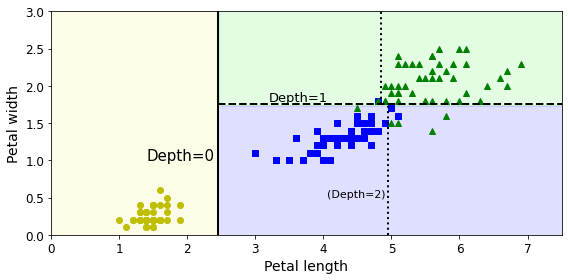

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

### MODEL INTERPRETATION: WHITE BOX VERSUS BLACK BOX

#### As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret. Such models are often called white box models. In contrast, as we will see, Random Forests or neural networks are generally considered black box models. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what actually contributed to this prediction: did the model recognize that person’s eyes? Her mouth? Her nose? Her shoes? Or even the couch that she was sitting on? Conversely, Decision Trees provide nice and simple classification rules that can even be applied manually if need be (e.g., for flower classification).

## Estimating Class Probabilities

#### For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris- Virginica (5/54). And of course if you ask it to predict the class, it should output Iris-Versicolor (class 1) since it has the highest probability.

In [22]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [34]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm

### Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees)

#### The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold tk (e.g., “petal length ≤ 2.45 cm”). How does it choose k and tk? It searches for the pair (k, tk) that produces the purest subsets (weighted by their size).The cost function that the algorithm tries to minimize is given by

![text](img/cap6/cart-cost.png)

#### Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub- subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity

#### hyperparameters (described in a moment) control additional stopping conditions (min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes).

#### As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at the top level, then repeats the process at each level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a reasonably good solution, but it is not guaranteed to be the optimal solution.

## Gini Impurity or Entropy?

#### The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered.It later spread to a wide variety of domains, including Shannon’s information theory, where it measures the average information content of a message:4 entropy is zero when all messages are identical.  In Machine Learning, it is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class

![text](img/cap6/entropy.png)

#### So should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees

## Regularization Hyperparameters

#### If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it. Such a model is often called a nonparametric model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

### To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called regularization.

### The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree.

### Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

In [47]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [48]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

Saving figure decision_tree_instability_plot


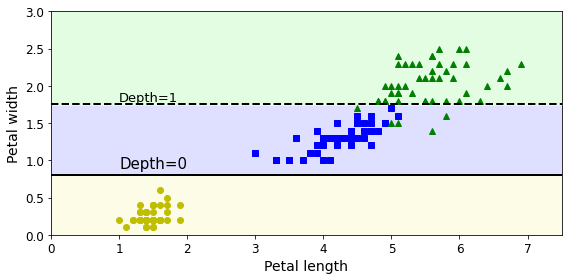

In [49]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

Saving figure min_samples_leaf_plot


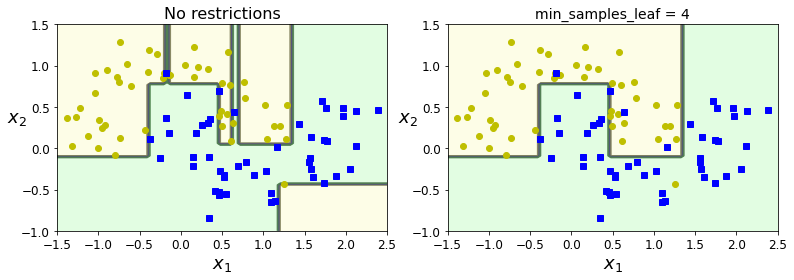

In [54]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

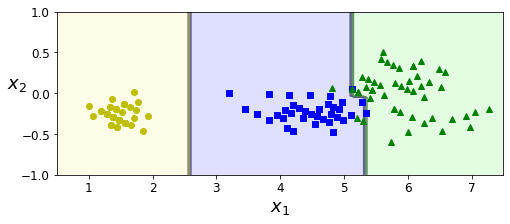

In [59]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(min_samples_leaf=4,random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

Saving figure sensitivity_to_rotation_plot


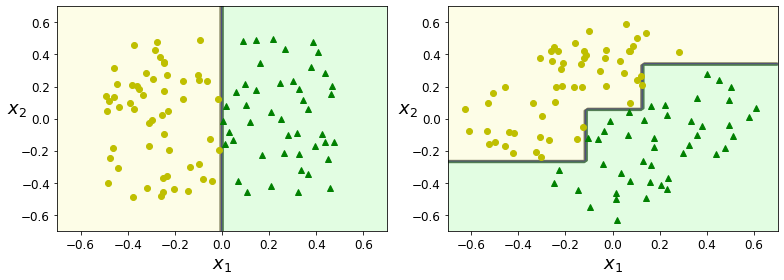

In [63]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

save_fig("sensitivity_to_rotation_plot")
plt.show()

## Regression trees